In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import datetime
from implementations import*


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


UsageError: Line magic function `%autoreload 2` not found.


In [8]:
from helpers import *

### Copie coller de  :https://www.kaggle.com/code/alexteboul/heart-disease-health-indicators-dataset-notebook
Important Risk Factors Research in the field has identified the following as important risk factors for heart disease and other chronic illnesses like diabetes (not in strict order of importance):

blood pressure (high)
cholesterol (high)
smoking
diabetes
obesity
age
sex
race
diet
exercise
alcohol consumption
BMI
Household Income
Marital Status
Sleep
Time since last checkup
Education
Health care coverage
Mental Health  



Selected Subset of Features from BRFSS 2015
Given these risk factors, I tried to select features (columns/questions) in the BRFSS related to these risk factors. To help understand what the columns mean, I consult the BRFSS 2015 Codebook to see the questions and information about the questions. I try to match the variable names in the codebook to the variable names in the dataset I downloaded from Kaggle. I also reference some of the same features chosen for a research paper by Zidian Xie et al for Building Risk Prediction Models for

## Data overview


In [9]:
#load data
PATH = "data/dataset/"
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data/dataset/", sub_sample=False)



In [17]:
print(f'Training Dataset x shape is {x_train.shape}')
print(f'Ground truth labels y shape is {y_train.shape}')
print(f'Test Dataset X shape is {x_test.shape}')

Training Dataset x shape is (328135, 320)
Ground truth labels y shape is (328135,)
Test Dataset X shape is (109379, 320)


We can see here that there are a lot of features (320), and that we should select some to prevent from non useful calculus.

In [13]:
print(train_ids)
print(test_ids)


[53 33 20 ... 39 33 32]
[44 27 35 ...  9 15 45]


Here the ids are not relevant : the 1st line is taken out, so we should make a headers file.

In [15]:
#load headers

with open(os.path.join(PATH, "x_train.csv"), "r") as file:
    header_line = file.readline()
    headers = header_line.strip().split(",")

# isolating the headers in the 'headers' list

print("Headers:")
print(headers)


Headers:
['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES', 'CELLFON3', 'LADULT', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CTELNUM1', 'CELLFON2', 'CADULT', 'PVTRESD2', 'CCLGHOUS', 'CSTATE', 'LANDLINE', 'HHADULT', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL2', 'NUMPHON2', 'CPDEMO1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2', 'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5', 'MAXDRNKS', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', '

We have to pay attention to the indices. In the code given in helpers.py :
```python
def load_csv_data(data_path, sub_sample=False):
#...Etc


train_ids = x_train[:, 0].astype(dtype=int)
test_ids = x_test[:, 0].astype(dtype=int)
x_train = x_train[:, 1:]
x_test = x_test[:, 1:]
```
For the following code we will do, the indice 200 will be for headers the 159th headers but the 158th data


# 1. Visualizing if our data is balanced or not


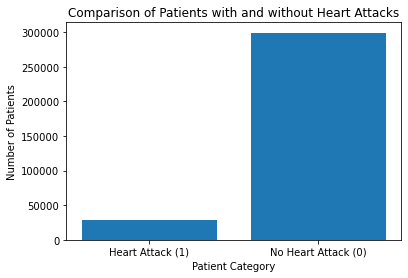

In [22]:
#counting the number of patients with a heart attack or not
count_y1 = np.sum(y_train == 1)
count_y0 = np.sum(y_train == 0)

# bar plot
categories = ['Heart Attack (1)', 'No Heart Attack (0)']
counts = [count_y1, count_y0]

plt.bar(categories, counts)
plt.xlabel('Patient Category')
plt.ylabel('Number of Patients')
plt.title('Comparison of Patients with and without Heart Attacks')
plt.show()


In [26]:
#Selecting an equal number of people with heart attack and those who has not

# Identifiez les indices des patients avec un arrêt cardiaque (y=1) et sans (y=0)
indices_y1 = np.where(y_train == 1)[0]
indices_y0 = np.where(y_train == 0)[0]

# Sélectionnez un nombre égal d'indices aléatoires pour les deux classes
num_samples = min(len(indices_y1), len(indices_y0))
selected_indices_y1 = np.random.choice(indices_y1, num_samples, replace=False)
selected_indices_y0 = np.random.choice(indices_y0, num_samples, replace=False)

print('indices selectionés:', selected_indices_y1)
print('indices selectionés y0:', selected_indices_y0)

# Combinez les indices sélectionnés pour former un ensemble de données équilibré
selected_indices = np.concatenate((selected_indices_y1, selected_indices_y0))

# Sélectionnez les données correspondantes à ces indices 
balanced_x_train = x_train[selected_indices]
balanced_y_train = y_train[selected_indices]


indices selectionés: [225109 125479  24933 ... 322108 308861 211955]
indices selectionés y0: [ 67514 288722  80842 ...  81344 267569 157934]


In [104]:
D= len(selected_indices)
print(D)



# Générer 10 indices de lignes aléatoires sans remplacement.
indices_aleatoires = np.random.choice(x_test.shape[0], size=D, replace=False)

# Sélectionner les lignes correspondantes à ces indices.
balanced_x_test = x_test[indices_aleatoires, :]

print(np.shape(balanced_x_test))

57950
(57950, 320)


### Verify our code, to check if we indeed have equal personne with HK and not



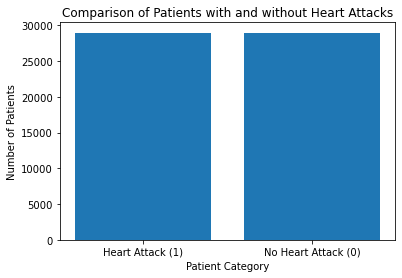

In [63]:

#counting the number of patients with a heart attack or not
count_y1 = np.sum(balanced_y_train == 1)
count_y0 = np.sum(balanced_y_train == 0)

# bar plot
categories = ['Heart Attack (1)', 'No Heart Attack (0)']
counts = [count_y1, count_y0]

plt.bar(categories, counts)
plt.xlabel('Patient Category')
plt.ylabel('Number of Patients')
plt.title('Comparison of Patients with and without Heart Attacks')
plt.show()


In [94]:
print(len(balanced_y_train))
print(np.shape(balanced_x_train))

57950
(57950, 320)


Here, we have shown that our data was umbalanced. This can make our model to be biased towards the majority class.
So we decided to take randomly the same number of persons that have had a heart attack and not.  
Now, we have 57950 datas.

# 2. Working on 1 feature : _SMOKER3


In [106]:
#extracting the feature _SMOKER3
indices_features = 258

x_train_extracted_balanced = balanced_x_train[:, indices_features]

print(np.shape(x_train_extracted_balanced))


print(headers[259])
print(x_train[:7,258])



(57950,)
_SMOKER3
[1. 1. 3. 1. 9. 4. 4.]


# 3. Working on the interesting features

### Selecting the interesting features and making a new x_data

Selecting only some features


In [83]:

#Creating an array features containing the selected features

selected_feature_indices= [231,232,233,235,238,239,237,247,255,260,264,265,266,277,278,288,302,314,320]

features = []

for feature_idx in selected_feature_indices:
    #print('feature n°', feature_idx,',',headers[feature_idx-1])
 
    # Select the specific feature column in the randomly selected balanced_x_train values
    feature_column = balanced_x_train[:, feature_idx-2]  # Utilisez feature_idx-2 car les indices commencent à 0 et il y a un decalage de 1 avec les ids
    #print('feature_column',feature_column[:7,])

    # Add the column to the list features
    features.append(feature_column)

# List into Numpy Array
X_select= np.array(features)

#Xhecking it contains the same number of wanted features, and balanced data.
np.shape(X_select)





(19, 57950)

Here, we have selected some interesting features, and we have equal y=0 and y=1 datas (randomly selected).
Printed just 7 per features, just to follow if it was the right data.
Note : we have selected the (i-1)th headers and the i-th features because they are shifted.

Indices in the tab: [231,232,233,235,238,239,237,247,255,260,264,265,266,277,278,288,302,314,320]
I had to put -2 for each bc the features are shifted from 2.  

For headers I only had to shift by one, bc as usual a list indices starts at 0. 

In [85]:
Headers = [headers[i-1] for i in selected_feature_indices]
y = balanced_y_train


### Visualising the impact of each feature on heart attack 

> Here we can see how the data is shared in each feature.

0
Feature _PNEUMO2 is continuous with a range from nan to nan.


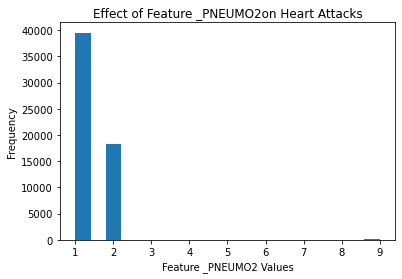

1
Feature _RFHLTH is discrete with 3 unique values.


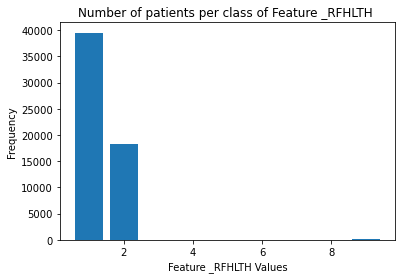

2
Feature _HCVU651 is discrete with 3 unique values.


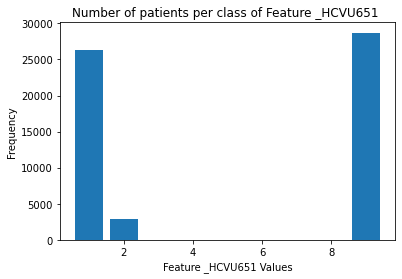

3
Feature _RFHYPE5 is discrete with 3 unique values.


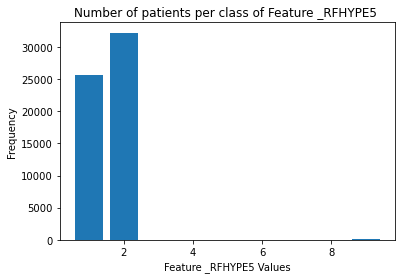

4
Feature _RFCHOL is continuous with a range from nan to nan.


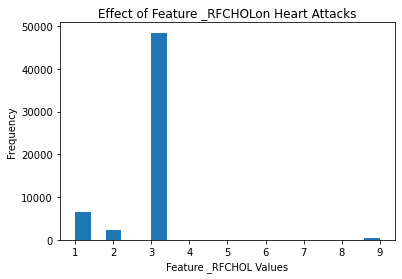

5
Feature _ASTHMS1 is discrete with 4 unique values.


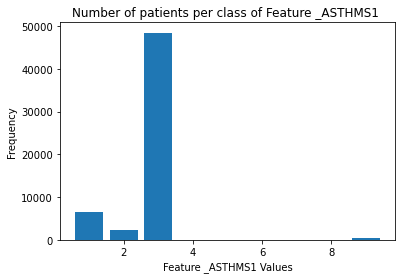

6
Feature _DRDXAR1 is continuous with a range from nan to nan.


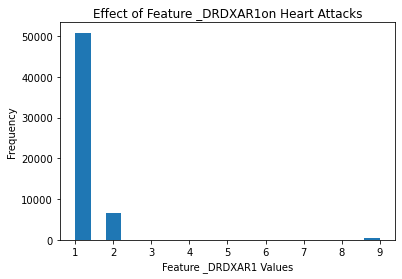

7
Feature _CASTHM1 is discrete with 3 unique values.


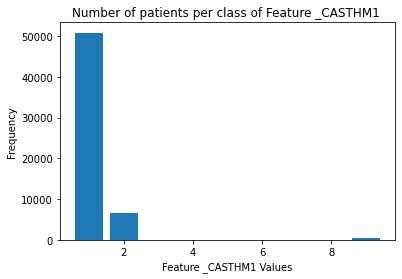

8
Feature _AGEG5YR is continuous with a range from 1.0 to 14.0.


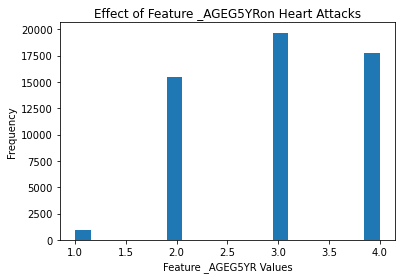

9
Feature _BMI5CAT is continuous with a range from nan to nan.


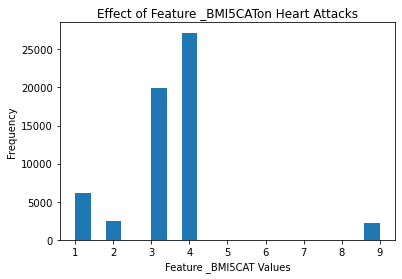

10
Feature _SMOKER3 is discrete with 5 unique values.


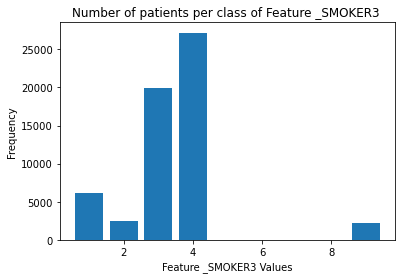

11
Feature _RFBING5 is discrete with 3 unique values.


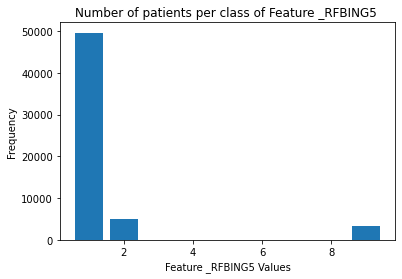

12
Feature _DRNKWEK is continuous with a range from 0.0 to 99900.0.


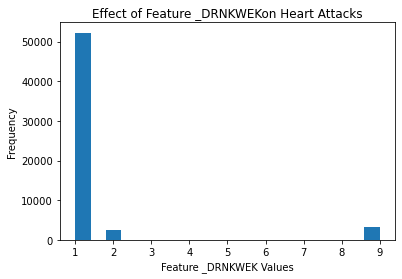

13
Feature _RFDRHV5 is discrete with 3 unique values.


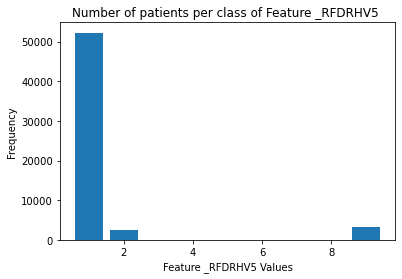

14
Feature _FRUTSUM is continuous with a range from nan to nan.


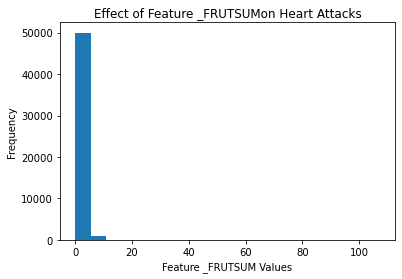

15
Feature _VEGESUM is continuous with a range from nan to nan.


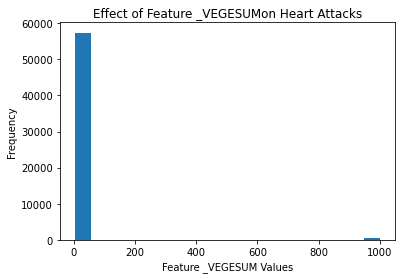

16
Feature MAXVO2_ is continuous with a range from 5.55 to 999.0.


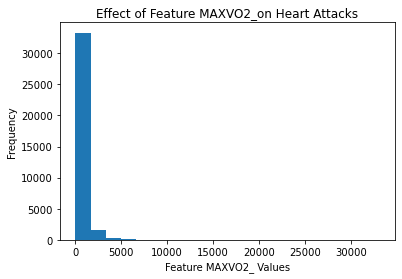

17
Feature PA1MIN_ is continuous with a range from nan to nan.


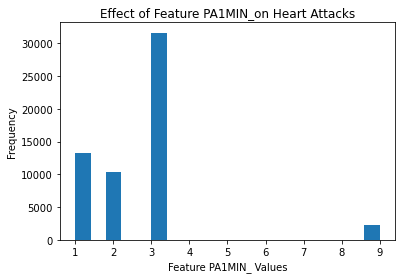

18
Feature _LMTACT1 is continuous with a range from nan to nan.


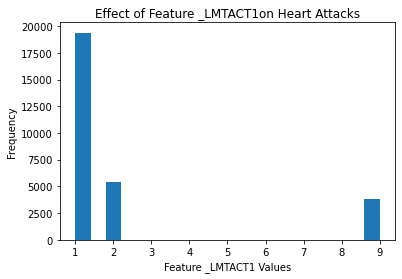

In [130]:
D = len(X_select)
 


for i in range(D):
    print(i)
    
   # Identify the type of data (discrete or continuous)
    unique_values, value_counts = np.unique(X_select[i-1], return_counts=True)
    
    
    if len(unique_values) <= 10:
        # If there are 10 or fewer unique values, consider it as discrete data
        print(f"Feature {Headers[i-1]} is discrete with {len(unique_values)} unique values.")

        # Create a bar chart to visualize the distribution of values
        
        plt.bar(unique_values, value_counts)
        plt.xlabel(f'Feature {Headers[i-1]} Values')
        plt.ylabel('Frequency')
        plt.title(f'Number of patients per class of Feature {Headers[i-1]} ')
        plt.show()
    else:
        # If there are more than 10 unique values, consider it as continuous data
        print(f"Feature {Headers[i-1]} is continuous with a range from {np.min(X_select[i-1])} to {np.max(X_select[i-1])}.")

        # Create a histogram to visualize the distribution of values
        plt.hist(X_select[i], bins=20)  # You can adjust the number of bins
        plt.xlabel(f'Feature {Headers[i-1]} Values')
        plt.ylabel('Frequency')
        plt.title(f'Effect of Feature {Headers[i-1]}on Heart Attacks')
        plt.show()


essai 1 :


IndexError: list index out of range

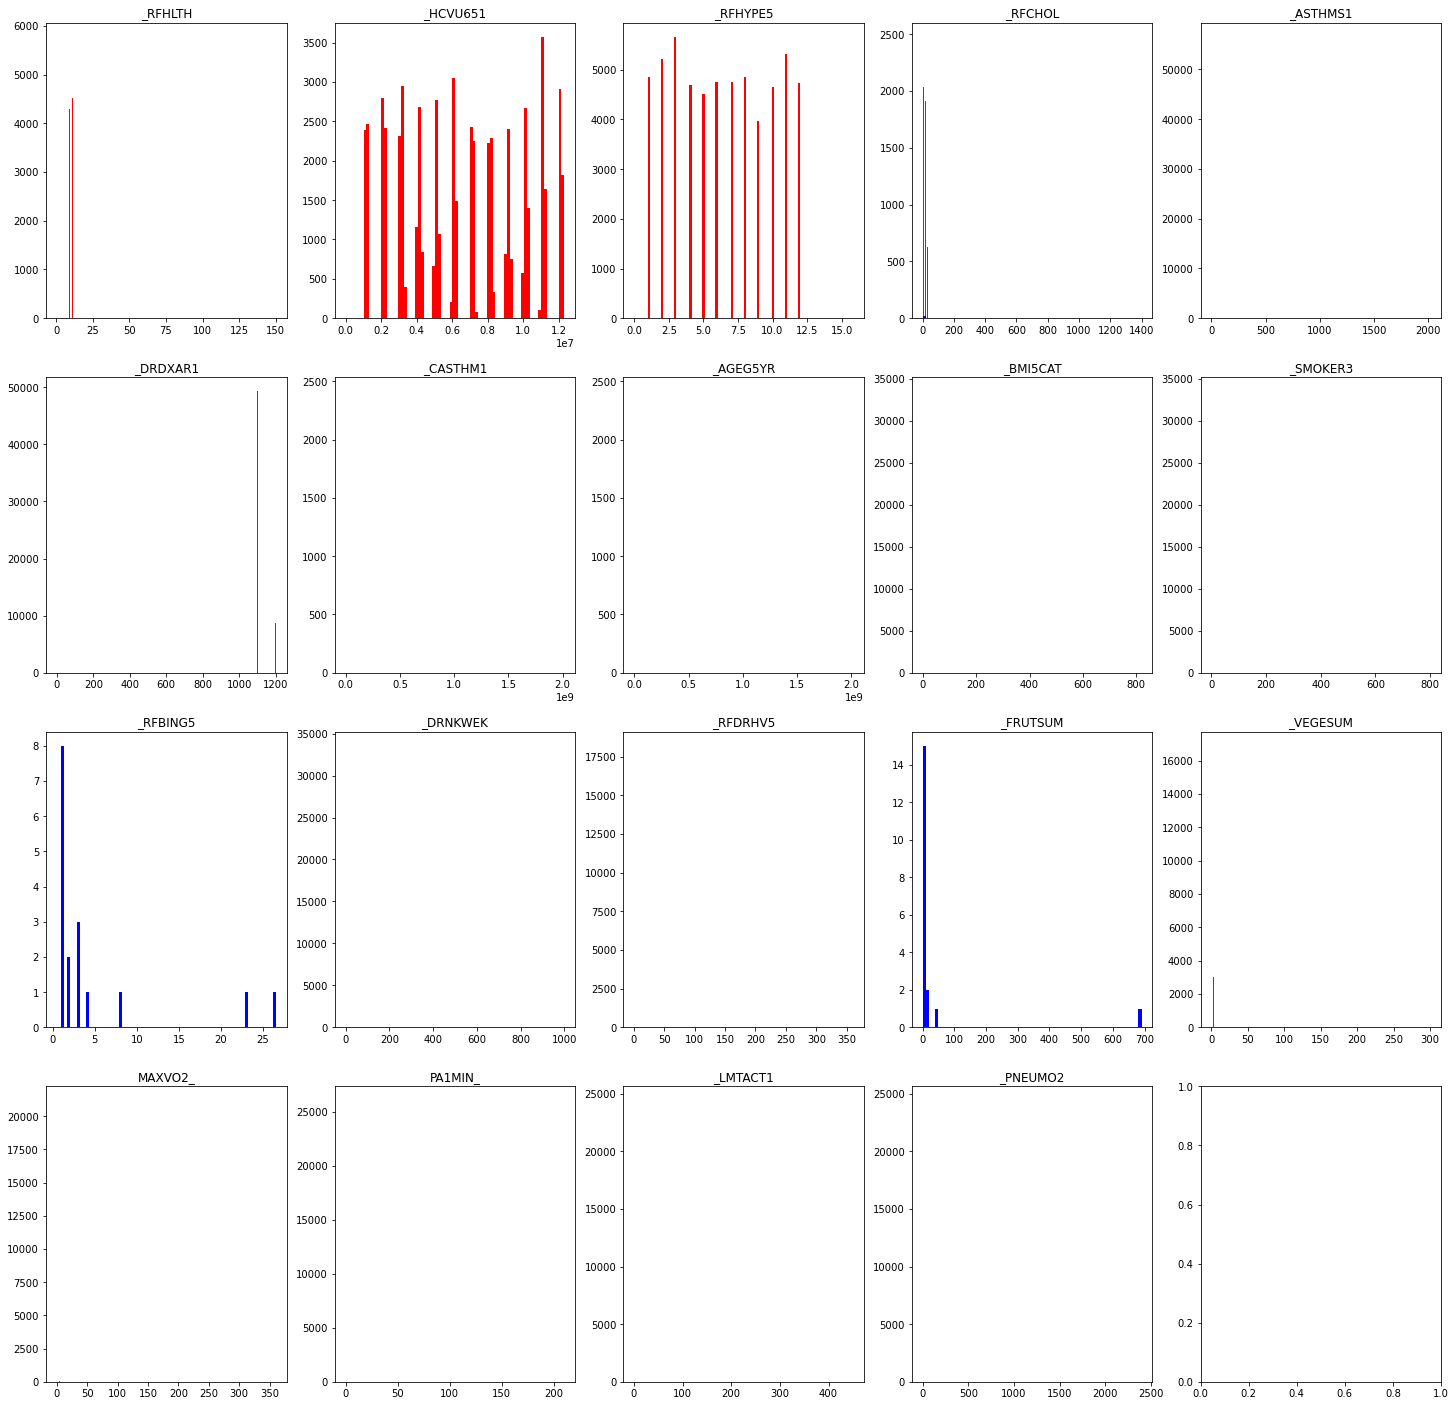

In [109]:
N_feature = D
plt.subplots(figsize=(25,25))

for i in range(0, N_feature):
    plt.subplot(4,5,i+1).set_title(Headers[i])
    plt.hist(balanced_x_test[:,i] ,70, histtype ='bar',color='r')
    plt.hist(X_select[:,i] ,bins = 70, histtype ='bar',color='b')


essaie 2

In [205]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de données
#y_train = np.array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1])  # Exemple de données pour y_train (0 ou 1)
selected_feature_indices = [231, 232, 233, 235, 238, 239, 237, 247, 255, 260, 264, 265, 266, 277, 278, 288, 302, 314, 320]

# Exemple de données pour x_train (57950 patients, 321 features)
#num_patients = 57950
#num_features = 321
#x_train = np.random.randint(1, 10, size=(num_patients, num_features))  # Exemple de données pour x_train

# Création du subplot
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

# Création des graphiques pour les features catégorielles
for i, feature_index in enumerate(selected_feature_indices):
    ax = axs[i // 4, i % 4]
    feature_data = x_train[:, feature_index]
    unique_classes = np.unique(feature_data)
    for class_value in unique_classes:
        patients_with_class = y_train[feature_data == class_value]
        patients_without_class = y_train[feature_data != class_value]
        counts = [np.sum(patients_with_class), np.sum(patients_without_class)]
        ax.bar(class_value, counts, label=f'Class {class_value}', color=['orange', 'blue'])
    ax.set_xlabel(f'Feature {feature_index}')
    ax.set_ylabel('Number of Patients')
    ax.legend()

# Création des graphiques pour les features continues
for i, feature_index in enumerate(selected_feature_indices):
    ax = axs[i // 4, i % 4]
    feature_data = x_train[:, feature_index]
    patients_with_condition = y_train
    bp = ax.boxplot([feature_data[patients_with_condition == 1], feature_data[patients_with_condition == 0]],
                    labels=['Heart Attack (1)', 'No Heart Attack (0)'], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['orange', 'blue']):
        patch.set_facecolor(color)
    ax.set_xlabel(f'Feature {feature_index}')
    ax.set_ylabel('Feature Value')

plt.show()


KeyboardInterrupt: 

essaie 3

Feature _RFHLTH is discrete with 3 unique values.


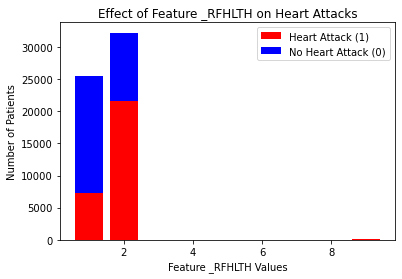

Feature _HCVU651 is discrete with 4 unique values.


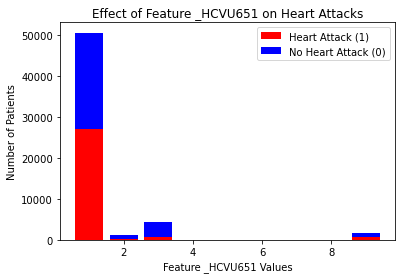

Feature _RFHYPE5 is continuous with a range from nan to nan.


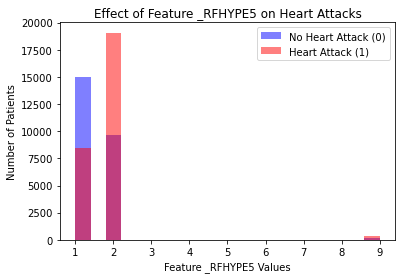

Feature _RFCHOL is discrete with 3 unique values.


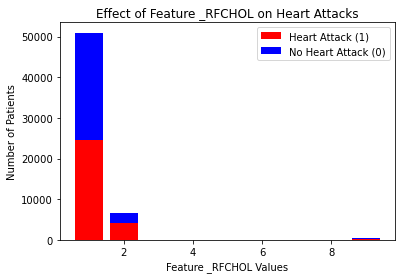

Feature _ASTHMS1 is discrete with 10 unique values.


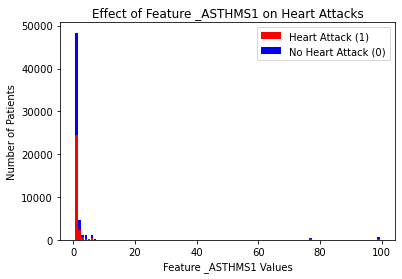

Feature _DRDXAR1 is discrete with 9 unique values.


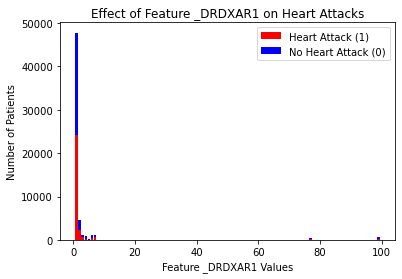

Feature _CASTHM1 is continuous with a range from nan to nan.


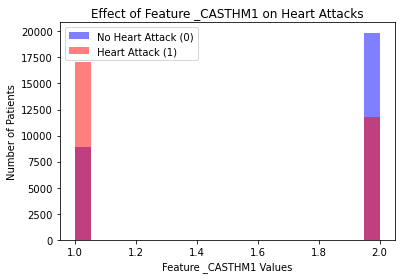

Feature _AGEG5YR is continuous with a range from 18.0 to 80.0.


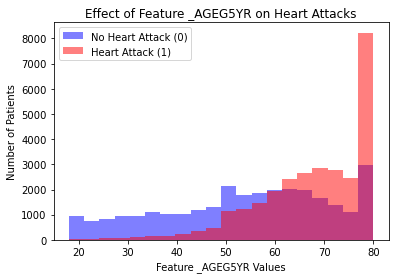

Feature _BMI5CAT is discrete with 7 unique values.


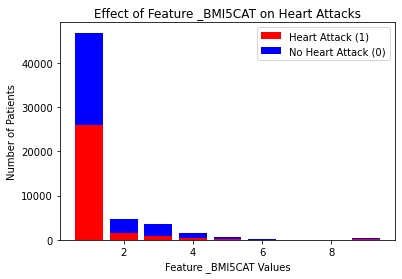

Feature _SMOKER3 is discrete with 4 unique values.


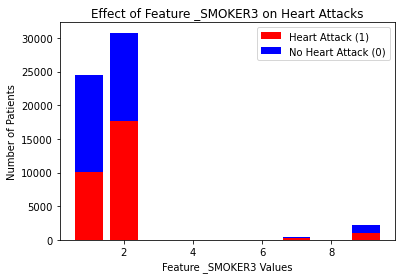

Feature _RFBING5 is discrete with 3 unique values.


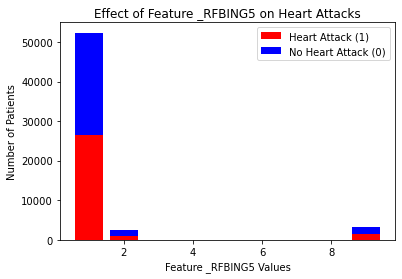

Feature _DRNKWEK is continuous with a range from nan to nan.


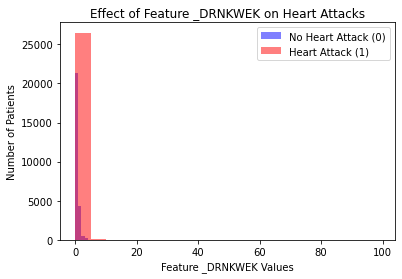

Feature _RFDRHV5 is continuous with a range from nan to nan.


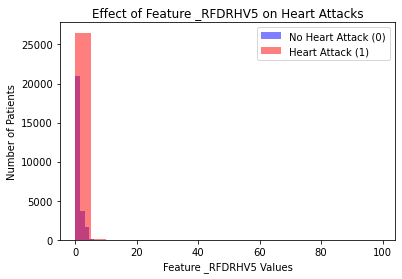

Feature _FRUTSUM is discrete with 3 unique values.


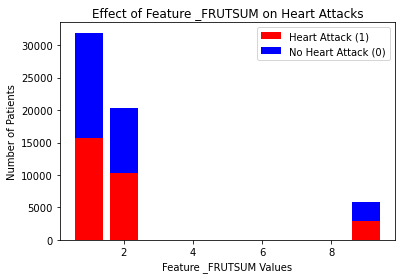

Feature _VEGESUM is discrete with 3 unique values.


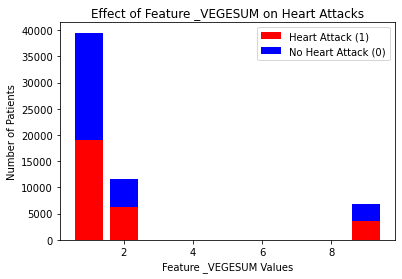

Feature MAXVO2_ is continuous with a range from nan to nan.


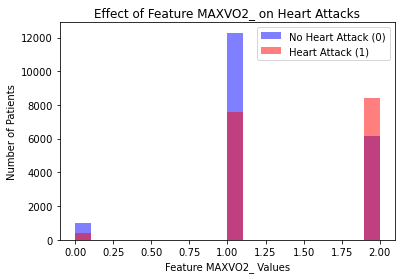

Feature PA1MIN_ is continuous with a range from nan to nan.


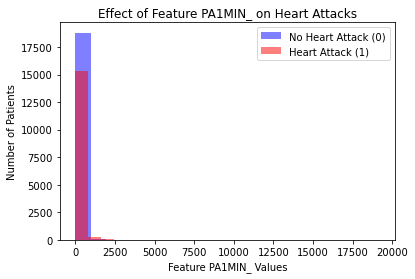

Feature _LMTACT1 is continuous with a range from nan to nan.


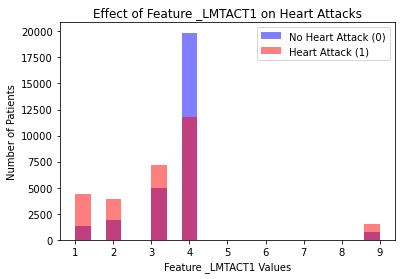

IndexError: index 320 is out of bounds for axis 1 with size 320

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que vous ayez déjà chargé vos données dans 'balanced_x_train' et 'balanced_y_train'
selected_feature_indices= [231,232,233,235,238,239,237,247,255,260,264,265,266,277,278,288,302,314,320]

for feature_idx in selected_feature_indices:
    
    head_name= headers[feature_idx-1]

    feature_values = balanced_x_train[:, feature_idx]  # Sélectionnez la colonne de la fonction spécifique
    heart_attack_values = balanced_y_train  # Valeurs de l'arrêt cardiaque (0 ou 1)

    # Identifier le type de données (discret ou continu)
    unique_values, value_counts = np.unique(feature_values, return_counts=True)

    if len(unique_values) <= 10:
        # S'il y a 10 valeurs uniques ou moins, considérez-le comme des données discrètes
        print(f"Feature {head_name} is discrete with {len(unique_values)} unique values.")

        # Compter le nombre de patients ayant un arrêt cardiaque (1) pour chaque valeur unique
        num_heart_attack = [np.sum((feature_values == unique_val) & (heart_attack_values == 1)) for unique_val in unique_values]

        # Créez un bar chart pour visualiser la distribution des valeurs
        fig, ax = plt.subplots()
        ax.bar(unique_values, num_heart_attack, color='r', label='Heart Attack (1)')
        ax.bar(unique_values, value_counts - num_heart_attack, bottom=num_heart_attack, color='b', label='No Heart Attack (0)')

        ax.set_xlabel(f'Feature {head_name} Values')
        ax.set_ylabel('Number of Patients')
        ax.set_title(f'Effect of Feature {head_name} on Heart Attacks')
        ax.legend()
        plt.show()
    else:
        # S'il y a plus de 10 valeurs uniques, considérez-le comme des données continues
        print(f"Feature {head_name} is continuous with a range from {np.min(feature_values)} to {np.max(feature_values)}.")

        # Créez un histogramme pour visualiser la distribution des valeurs
        fig, ax = plt.subplots()
        ax.hist(feature_values[heart_attack_values == 0], bins=20, color='b', alpha=0.5, label='No Heart Attack (0)')
        ax.hist(feature_values[heart_attack_values == 1], bins=20, color='r', alpha=0.5, label='Heart Attack (1)')

        ax.set_xlabel(f'Feature {head_name} Values')
        ax.set_ylabel('Number of Patients')
        ax.set_title(f'Effect of Feature {head_name} on Heart Attacks')
        ax.legend()
        plt.show()


# DIVISER LE DATA EN TRAIN ET TEST


In [ ]:


# Set a random seed for reproducibility
np.random.seed(42)

# Shuffle the data randomly
indices = np.random.permutation(len(X))


# Specify the proportion of data to use for the test set (in this example, 20%)
test_size = 0.2
split_index = int(len(X) * (1 - test_size))

# Split the data into training and testing sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# You can now use X_train and y_train to train your model
# and X_test and y_test to evaluate the model's performance.


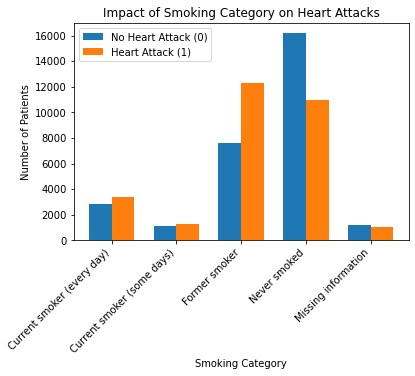

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Define the categories for smoking with corresponding names
category_names = {
    1: "Current smoker (every day)",
    2: "Current smoker (some days)",
    3: "Former smoker",
    4: "Never smoked",
    9: "Missing information"
}

# Create arrays to count the occurrences of 0 (No Heart Attack) and 1 (Heart Attack) for each category
categories = list(category_names.keys())
counts_zero = np.zeros(len(categories))
counts_one = np.zeros(len(categories))

# Count the number of patients with No Heart Attack (0) and Heart Attack (1) in each category
for i, category in enumerate(categories):
    for j in range(len(balanced_y_train)):
        if x_train_extracted_balanced[j] == category:
            if balanced_y_train[j] == 0:
                counts_zero[i] += 1
            elif balanced_y_train[j] == 1:
                counts_one[i] += 1

# Create a bar chart
width = 0.35
x = np.arange(len(categories))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, counts_zero, width, label='No Heart Attack (0)')
rects2 = ax.bar(x + width/2, counts_one, width, label='Heart Attack (1)')

ax.set_xlabel('Smoking Category')
ax.set_ylabel('Number of Patients')
ax.set_title('Impact of Smoking Category on Heart Attacks')
ax.set_xticks(x)
# Use category names as labels for the x-axis
ax.set_xticklabels([category_names[category] for category in categories], rotation=45, ha='right')
ax.legend()

plt.show()


Feature 230 is discrete with 3 unique values.


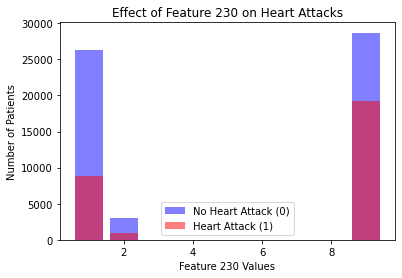

Feature 231 is discrete with 3 unique values.


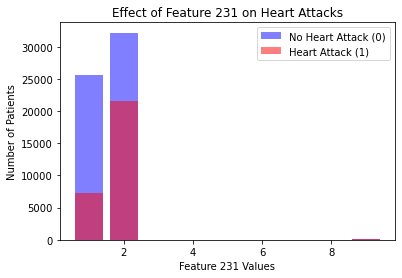

Feature 232 is discrete with 4 unique values.


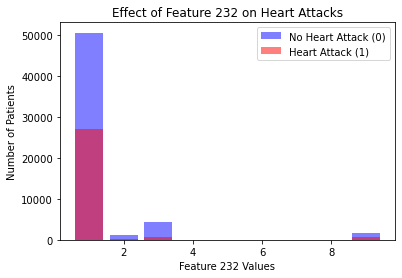

Feature 234 is discrete with 3 unique values.


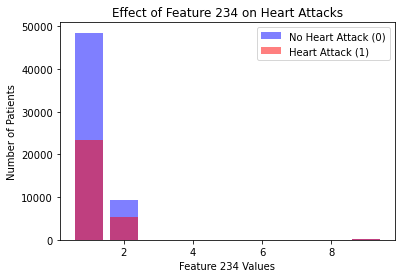

Feature 237 is continuous with a range from nan to nan.


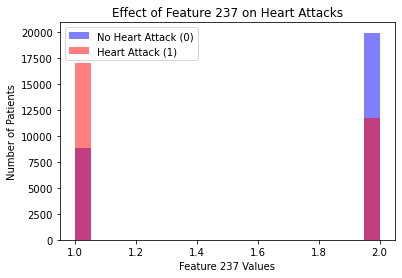

Feature 238 is discrete with 10 unique values.


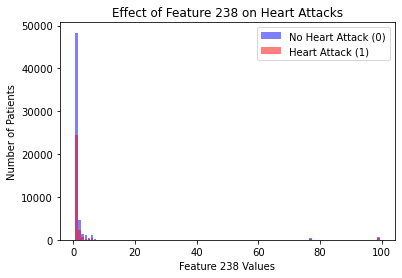

Feature 236 is discrete with 4 unique values.


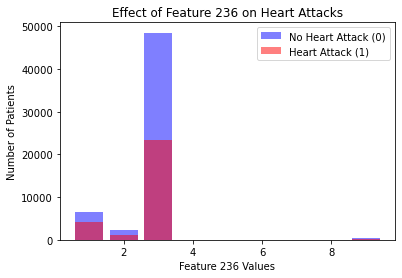

Feature 264 is discrete with 3 unique values.


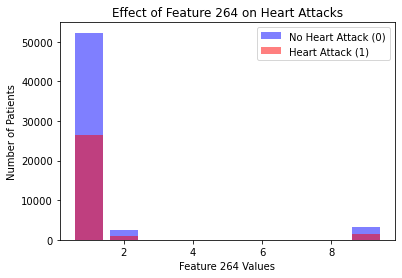

Feature 276 is continuous with a range from nan to nan.


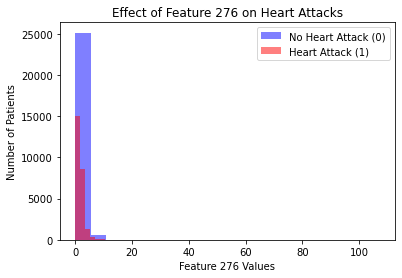

Feature 277 is discrete with 3 unique values.


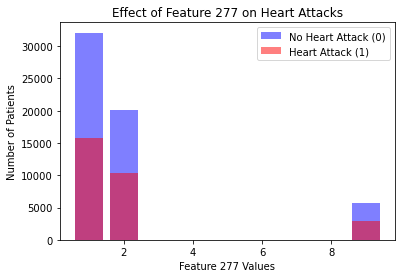

Feature 287 is continuous with a range from 0.95 to 999.0.


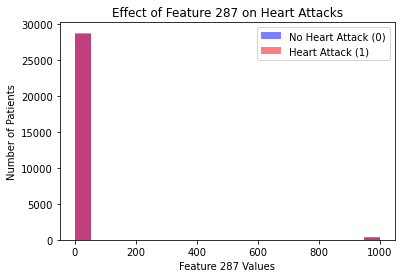

Feature 301 is continuous with a range from nan to nan.


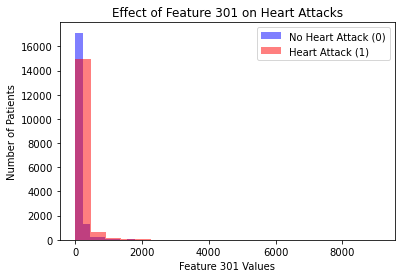

Feature 313 is continuous with a range from nan to nan.


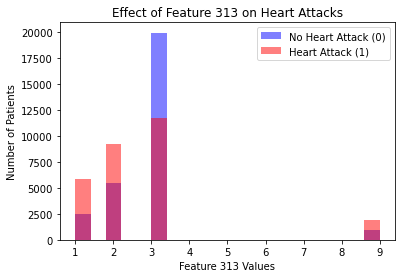

Feature 319 is continuous with a range from nan to nan.


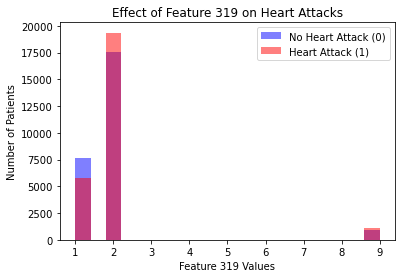

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que vous ayez déjà chargé vos données dans 'balanced_x_train' et 'balanced_y_train'
selected_feature_indices = [230, 231, 232, 234, 237, 238, 236, 264, 276, 277, 287, 301, 313, 319]

for feature_idx in selected_feature_indices:
    feature_values = balanced_x_train[:, feature_idx]  # Sélectionnez la colonne de la fonction spécifique
    heart_attack_values = balanced_y_train  # Valeurs de l'arrêt cardiaque (0 ou 1)

    # Identifier le type de données (discret ou continu)
    unique_values, value_counts = np.unique(feature_values, return_counts=True)

    if len(unique_values) <= 10:
        # Si il y a 10 valeurs uniques ou moins, considérez-le comme des données discrètes
        print(f"Feature {feature_idx} is discrete with {len(unique_values)} unique values.")

        # Créez un bar chart pour visualiser la distribution des valeurs
        fig, ax = plt.subplots()
        ax.bar(unique_values, value_counts, color='b', alpha=0.5, label='No Heart Attack (0)')
        
        # Comptez le nombre de patients ayant un arrêt cardiaque (1) pour chaque valeur unique
        num_heart_attack = [np.sum((feature_values == unique_val) & (heart_attack_values == 1)) for unique_val in unique_values]
        ax.bar(unique_values, num_heart_attack, color='r', alpha=0.5, label='Heart Attack (1)')

        ax.set_xlabel(f'Feature {feature_idx} Values')
        ax.set_ylabel('Number of Patients')
        ax.set_title(f'Effect of Feature {feature_idx} on Heart Attacks')
        ax.legend()
        plt.show()
    else:
        # Si il y a plus de 10 valeurs uniques, considérez-le comme des données continues
        print(f"Feature {feature_idx} is continuous with a range from {np.min(feature_values)} to {np.max(feature_values)}.")

        # Créez un histogramme pour visualiser la distribution des valeurs
        fig, ax = plt.subplots()
        ax.hist(feature_values[heart_attack_values == 0], bins=20, color='b', alpha=0.5, label='No Heart Attack (0)')
        ax.hist(feature_values[heart_attack_values == 1], bins=20, color='r', alpha=0.5, label='Heart Attack (1)')

        ax.set_xlabel(f'Feature {feature_idx} Values')
        ax.set_ylabel('Number of Patients')
        ax.set_title(f'Effect of Feature {feature_idx} on Heart Attacks')
        ax.legend()
        plt.show()
